## The Darcy's equation

We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Fourier Neural Operator method

### (2.1) Prepare data

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'DarcyFlow_pwc'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/pwc_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/pwc_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
from Utils.utils import *
n_train, n_test = 1000, 20
#
def get_data(data, ndata, dtype, res_coe=29, res_test=29*5, n0=0):
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    a[a==1.] = 10.; a[a==0.] = 5.;
    u = np2tensor(np.array(data["sol_fem"][...,n0:n0+ndata]).T, dtype)
    #
    X_coe, Y_coe = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X_coe.ravel(), Y_coe.ravel()]).T, dtype)
    gridx = mesh.reshape(1, res_coe, res_coe, 2)
    #
    ax = torch.cat([a.reshape(ndata, res_coe, res_coe,1), gridx.repeat(ndata, 1, 1, 1)], dim=-1)
    try:
        u = u.reshape(ndata, res_coe, res_coe, 1)
    except:
        X_sol, Y_sol = np.array(data['X_sol']).T, np.array(data['Y_sol']).T
        mesh = np2tensor(np.vstack([X_sol.ravel(), Y_sol.ravel()]).T, dtype)
        gridx = mesh.reshape(1, res_test, res_test, 2)
        #
        u = u.reshape(ndata, res_test, res_test, 1)
    
    return ax, u, gridx.reshape(-1,2)
#
ax_train, u_train, grid_train = get_data(data_train, n_train, dtype)
ax_test, u_test, grid_test = get_data(data_test, n_test, dtype)
#
print('The shape of ax_train:', ax_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of grid_train:', grid_train.shape)
print('The shape of ax_test:', ax_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of grid_test:', grid_test.shape)

<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
The shape of ax_train: torch.Size([1000, 29, 29, 3])
The shape of u_train: torch.Size([1000, 29, 29, 1])
The shape of grid_train: torch.Size([841, 2])
The shape of ax_test: torch.Size([20, 29, 29, 3])
The shape of u_test: torch.Size([20, 29, 29, 1])
The shape of grid_test: torch.Size([841, 2])


### (2.2) Define the loss class

In [2]:
###############################
# Set normalizer
###############################
from Utils.Normalizer import *
normalizer_ax = UnitGaussianNormalizer(ax_train.to(device))
normalizer_u = UnitGaussianNormalizer(u_train.to(device))

###############################
# Define Loss Class
###############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']

    def Loss_data(self, ax, u):
        ''' '''
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.model_u(ax_norm)
        #
        try: 
            u_norm = normalizer_u.encode(u)
            return self.solver.getLoss(u_pred_norm, u_norm)
        except:
            return torch.tensor(0.)
        
        return loss

    def Error(self, ax, u):
        ''' '''
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.model_u(ax_norm)
        #
        try: 
            u_norm = normalizer_u.encode(u)
            return self.solver.getError(u_pred_norm, u_norm)
        except:
            return torch.tensor(0.)

######################################
# Steups of the model and training 
######################################
from Solvers.FNO import FNO
solver = FNO.Solver(device, dtype)
netType = 'FNO2d'
model_u = solver.getModel(in_size=3, out_size=1, modes=[12, 12], hidden_list=[64]*4, 
                          activation='ReLU', netType='FNO2d')
######################################
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')

4,743,937 training parameters.


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
# Train the model
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR')
solver.train(LossClass, ax_train, u_train, ax_test, u_test, 
             batch_size=50, epochs=1000,  epoch_show=10,
             **{'save_path':f'saved_models/{netType}/'})

  1%|▊                                                                               | 10/1000 [00:02<03:46,  4.38it/s]

Epoch:10 Time:2.7686, loss_train:1.880273, loss_test:1.927391
          lr: 0.001 err_test 0.07370468229055405


  2%|█▌                                                                              | 20/1000 [00:04<02:54,  5.60it/s]

Epoch:20 Time:4.6333, loss_train:1.052608, loss_test:1.023420
          lr: 0.001 err_test 0.039475392550230026


  3%|██▍                                                                             | 30/1000 [00:06<02:28,  6.52it/s]

Epoch:30 Time:6.3381, loss_train:1.002155, loss_test:0.806491
          lr: 0.001 err_test 0.031183717772364616


  4%|███▎                                                                            | 41/1000 [00:08<02:31,  6.33it/s]

Epoch:40 Time:8.0604, loss_train:0.797307, loss_test:0.856781
          lr: 0.001 err_test 0.03296223282814026


  5%|████                                                                            | 51/1000 [00:09<02:21,  6.70it/s]

Epoch:50 Time:9.5933, loss_train:0.732097, loss_test:0.900666
          lr: 0.001 err_test 0.034706469625234604


  6%|████▉                                                                           | 61/1000 [00:11<02:29,  6.29it/s]

Epoch:60 Time:11.1395, loss_train:0.688416, loss_test:0.628349
          lr: 0.001 err_test 0.02412216179072857


  7%|█████▋                                                                          | 71/1000 [00:12<02:37,  5.91it/s]

Epoch:70 Time:12.7574, loss_train:0.659478, loss_test:0.520537
          lr: 0.001 err_test 0.020138083025813103


  8%|██████▍                                                                         | 81/1000 [00:14<02:15,  6.79it/s]

Epoch:80 Time:14.2474, loss_train:0.650757, loss_test:0.549721
          lr: 0.001 err_test 0.02111429162323475


  9%|███████▎                                                                        | 91/1000 [00:15<02:15,  6.73it/s]

Epoch:90 Time:15.8031, loss_train:0.659328, loss_test:0.552401
          lr: 0.001 err_test 0.021142924204468727


 10%|███████▉                                                                       | 101/1000 [00:17<02:11,  6.83it/s]

Epoch:100 Time:17.2680, loss_train:0.830140, loss_test:0.728766
          lr: 0.001 err_test 0.02855301834642887


 11%|████████▊                                                                      | 111/1000 [00:18<02:10,  6.82it/s]

Epoch:110 Time:18.7344, loss_train:0.989583, loss_test:0.874681
          lr: 0.001 err_test 0.033850982785224915


 12%|█████████▌                                                                     | 121/1000 [00:20<02:25,  6.03it/s]

Epoch:120 Time:20.3765, loss_train:0.547566, loss_test:0.551799
          lr: 0.001 err_test 0.021291768178343773


 13%|██████████▎                                                                    | 131/1000 [00:21<02:07,  6.80it/s]

Epoch:130 Time:21.8427, loss_train:0.562436, loss_test:0.503463
          lr: 0.001 err_test 0.019360706210136414


 14%|███████████▏                                                                   | 141/1000 [00:23<02:05,  6.82it/s]

Epoch:140 Time:23.3075, loss_train:0.594949, loss_test:0.553088
          lr: 0.001 err_test 0.021432433277368546


 15%|███████████▉                                                                   | 151/1000 [00:24<02:04,  6.84it/s]

Epoch:150 Time:24.7724, loss_train:0.626140, loss_test:0.543868
          lr: 0.001 err_test 0.021156679838895798


 16%|████████████▋                                                                  | 161/1000 [00:26<02:02,  6.84it/s]

Epoch:160 Time:26.2372, loss_train:0.572552, loss_test:0.494334
          lr: 0.001 err_test 0.01876118779182434


 17%|█████████████▌                                                                 | 171/1000 [00:27<02:01,  6.82it/s]

Epoch:170 Time:27.7018, loss_train:0.674074, loss_test:0.608790
          lr: 0.001 err_test 0.023392127826809883


 18%|██████████████▎                                                                | 181/1000 [00:29<02:00,  6.82it/s]

Epoch:180 Time:29.1706, loss_train:0.630622, loss_test:0.537280
          lr: 0.001 err_test 0.02076401375234127


 19%|███████████████                                                                | 191/1000 [00:30<01:58,  6.82it/s]

Epoch:190 Time:30.6354, loss_train:0.526851, loss_test:0.698758
          lr: 0.001 err_test 0.02695927955210209


 20%|███████████████▊                                                               | 200/1000 [00:32<01:57,  6.82it/s]

Epoch:200 Time:32.0994, loss_train:0.520679, loss_test:0.466437
          lr: 0.0005 err_test 0.017938286066055298


 21%|████████████████▋                                                              | 211/1000 [00:34<02:06,  6.22it/s]

Epoch:210 Time:33.9930, loss_train:0.281004, loss_test:0.325684
          lr: 0.0005 err_test 0.012574818916618824


 22%|█████████████████▍                                                             | 221/1000 [00:35<01:56,  6.68it/s]

Epoch:220 Time:35.5237, loss_train:0.314037, loss_test:0.292307
          lr: 0.0005 err_test 0.01121972780674696


 23%|██████████████████▏                                                            | 231/1000 [00:37<01:52,  6.83it/s]

Epoch:230 Time:36.9885, loss_train:0.311252, loss_test:0.336238
          lr: 0.0005 err_test 0.012994945049285889


 24%|███████████████████                                                            | 241/1000 [00:38<01:51,  6.84it/s]

Epoch:240 Time:38.4513, loss_train:0.279843, loss_test:0.260276
          lr: 0.0005 err_test 0.010163669474422932


 25%|███████████████████▊                                                           | 251/1000 [00:40<02:03,  6.05it/s]

Epoch:250 Time:39.9858, loss_train:0.301989, loss_test:0.230537
          lr: 0.0005 err_test 0.008866819553077221


 26%|████████████████████▌                                                          | 261/1000 [00:41<01:48,  6.81it/s]

Epoch:260 Time:41.4633, loss_train:0.290302, loss_test:0.292257
          lr: 0.0005 err_test 0.011243785731494427


 27%|█████████████████████▍                                                         | 271/1000 [00:43<01:46,  6.84it/s]

Epoch:270 Time:42.9260, loss_train:0.291157, loss_test:0.283572
          lr: 0.0005 err_test 0.010957845486700535


 28%|██████████████████████▏                                                        | 281/1000 [00:44<01:45,  6.84it/s]

Epoch:280 Time:44.3886, loss_train:0.329174, loss_test:0.368063
          lr: 0.0005 err_test 0.013924730010330677


 29%|██████████████████████▉                                                        | 291/1000 [00:45<01:43,  6.83it/s]

Epoch:290 Time:45.8535, loss_train:0.291344, loss_test:0.269707
          lr: 0.0005 err_test 0.010507620871067047


 30%|███████████████████████▊                                                       | 301/1000 [00:47<01:42,  6.83it/s]

Epoch:300 Time:47.3173, loss_train:0.284539, loss_test:0.391872
          lr: 0.0005 err_test 0.015101330354809761


 31%|████████████████████████▌                                                      | 311/1000 [00:48<01:40,  6.83it/s]

Epoch:310 Time:48.7821, loss_train:0.386659, loss_test:0.340040
          lr: 0.0005 err_test 0.013283746317029


 32%|█████████████████████████▎                                                     | 321/1000 [00:50<01:40,  6.79it/s]

Epoch:320 Time:50.2458, loss_train:0.280032, loss_test:0.283807
          lr: 0.0005 err_test 0.011038938537240028


 33%|██████████████████████████▏                                                    | 331/1000 [00:51<01:37,  6.83it/s]

Epoch:330 Time:51.7127, loss_train:0.302888, loss_test:0.337881
          lr: 0.0005 err_test 0.012938523665070534


 34%|██████████████████████████▉                                                    | 341/1000 [00:53<01:36,  6.83it/s]

Epoch:340 Time:53.1774, loss_train:0.288500, loss_test:0.298880
          lr: 0.0005 err_test 0.01143240462988615


 35%|███████████████████████████▋                                                   | 350/1000 [00:54<01:35,  6.83it/s]

Epoch:350 Time:54.6412, loss_train:0.275596, loss_test:0.278251
          lr: 0.0005 err_test 0.010675228200852871


 36%|████████████████████████████▌                                                  | 361/1000 [00:56<01:34,  6.77it/s]

Epoch:360 Time:56.2002, loss_train:0.303513, loss_test:0.267427
          lr: 0.0005 err_test 0.010350021533668041


 37%|█████████████████████████████▎                                                 | 371/1000 [00:57<01:32,  6.84it/s]

Epoch:370 Time:57.6640, loss_train:0.334877, loss_test:0.300896
          lr: 0.0005 err_test 0.01161919068545103


 38%|██████████████████████████████                                                 | 381/1000 [00:59<01:30,  6.84it/s]

Epoch:380 Time:59.1290, loss_train:0.320998, loss_test:0.303117
          lr: 0.0005 err_test 0.011853461153805256


 39%|██████████████████████████████▉                                                | 391/1000 [01:00<01:29,  6.80it/s]

Epoch:390 Time:60.5996, loss_train:0.331456, loss_test:0.289728
          lr: 0.0005 err_test 0.01113452110439539


 40%|███████████████████████████████▌                                               | 400/1000 [01:02<01:27,  6.88it/s]

Epoch:400 Time:62.0563, loss_train:0.302154, loss_test:0.340362
          lr: 0.00025 err_test 0.013143558986485004


 41%|████████████████████████████████▍                                              | 410/1000 [01:03<01:43,  5.70it/s]

Epoch:410 Time:63.8779, loss_train:0.168028, loss_test:0.172853
          lr: 0.00025 err_test 0.0066518099047243595


 42%|█████████████████████████████████▎                                             | 421/1000 [01:05<01:36,  5.97it/s]

Epoch:420 Time:65.4965, loss_train:0.156750, loss_test:0.137928
          lr: 0.00025 err_test 0.005305740982294083


 43%|██████████████████████████████████                                             | 431/1000 [01:07<01:26,  6.59it/s]

Epoch:430 Time:67.0449, loss_train:0.149540, loss_test:0.151712
          lr: 0.00025 err_test 0.005786434281617403


 44%|██████████████████████████████████▊                                            | 441/1000 [01:08<01:21,  6.83it/s]

Epoch:440 Time:68.5057, loss_train:0.162256, loss_test:0.143596
          lr: 0.00025 err_test 0.005522705148905516


 45%|███████████████████████████████████▋                                           | 451/1000 [01:10<01:20,  6.85it/s]

Epoch:450 Time:69.9644, loss_train:0.189714, loss_test:0.197853
          lr: 0.00025 err_test 0.007577856071293354


 46%|████████████████████████████████████▍                                          | 461/1000 [01:11<01:18,  6.86it/s]

Epoch:460 Time:71.4242, loss_train:0.162542, loss_test:0.160069
          lr: 0.00025 err_test 0.006177495699375868


 47%|█████████████████████████████████████▏                                         | 471/1000 [01:13<01:17,  6.85it/s]

Epoch:470 Time:72.8851, loss_train:0.175631, loss_test:0.156229
          lr: 0.00025 err_test 0.006087380927056074


 48%|█████████████████████████████████████▉                                         | 481/1000 [01:14<01:15,  6.86it/s]

Epoch:480 Time:74.3388, loss_train:0.160401, loss_test:0.203572
          lr: 0.00025 err_test 0.007749001961201429


 49%|██████████████████████████████████████▊                                        | 491/1000 [01:15<01:14,  6.83it/s]

Epoch:490 Time:75.8036, loss_train:0.167712, loss_test:0.140441
          lr: 0.00025 err_test 0.005457237362861633


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:17<01:12,  6.87it/s]

Epoch:500 Time:77.2604, loss_train:0.280001, loss_test:0.328890
          lr: 0.00025 err_test 0.012502788566052914


 51%|████████████████████████████████████████▎                                      | 511/1000 [01:18<01:11,  6.85it/s]

Epoch:510 Time:78.7201, loss_train:0.173683, loss_test:0.204328
          lr: 0.00025 err_test 0.00792947132140398


 52%|█████████████████████████████████████████▏                                     | 521/1000 [01:20<01:09,  6.86it/s]

Epoch:520 Time:80.1800, loss_train:0.140228, loss_test:0.146031
          lr: 0.00025 err_test 0.005674377083778381


 53%|█████████████████████████████████████████▉                                     | 531/1000 [01:21<01:08,  6.86it/s]

Epoch:530 Time:81.6387, loss_train:0.146111, loss_test:0.131196
          lr: 0.00025 err_test 0.00511529017239809


 54%|██████████████████████████████████████████▋                                    | 541/1000 [01:23<01:07,  6.85it/s]

Epoch:540 Time:83.0975, loss_train:0.166694, loss_test:0.158746
          lr: 0.00025 err_test 0.0061252787709236145


 55%|███████████████████████████████████████████▌                                   | 551/1000 [01:24<01:07,  6.70it/s]

Epoch:550 Time:84.6424, loss_train:0.155382, loss_test:0.135850
          lr: 0.00025 err_test 0.0052380007691681385


 56%|████████████████████████████████████████████▎                                  | 561/1000 [01:26<01:04,  6.85it/s]

Epoch:560 Time:86.1042, loss_train:0.199156, loss_test:0.147510
          lr: 0.00025 err_test 0.005714701022952795


 57%|█████████████████████████████████████████████                                  | 571/1000 [01:27<01:02,  6.86it/s]

Epoch:570 Time:87.5650, loss_train:0.151227, loss_test:0.142364
          lr: 0.00025 err_test 0.005598820745944977


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [01:29<01:00,  6.88it/s]

Epoch:580 Time:89.0238, loss_train:0.176216, loss_test:0.155202
          lr: 0.00025 err_test 0.005948415491729975


 59%|██████████████████████████████████████████████▋                                | 591/1000 [01:30<01:03,  6.45it/s]

Epoch:590 Time:90.5657, loss_train:0.145856, loss_test:0.132409
          lr: 0.00025 err_test 0.00509002897888422


 60%|███████████████████████████████████████████████▍                               | 600/1000 [01:32<00:58,  6.86it/s]

Epoch:600 Time:92.0235, loss_train:0.168213, loss_test:0.142870
          lr: 0.000125 err_test 0.005461019929498434


 61%|████████████████████████████████████████████████▎                              | 611/1000 [01:34<01:00,  6.38it/s]

Epoch:610 Time:93.9161, loss_train:0.085017, loss_test:0.084150
          lr: 0.000125 err_test 0.003235396696254611


 62%|█████████████████████████████████████████████████                              | 621/1000 [01:35<00:56,  6.73it/s]

Epoch:620 Time:95.4602, loss_train:0.101165, loss_test:0.092561
          lr: 0.000125 err_test 0.00353354774415493


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [01:37<00:53,  6.85it/s]

Epoch:630 Time:96.9219, loss_train:0.083434, loss_test:0.082082
          lr: 0.000125 err_test 0.0031338490080088377


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [01:38<00:52,  6.88it/s]

Epoch:640 Time:98.3766, loss_train:0.084739, loss_test:0.082127
          lr: 0.000125 err_test 0.0031574585009366274


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [01:39<00:50,  6.85it/s]

Epoch:650 Time:99.8344, loss_train:0.093172, loss_test:0.116550
          lr: 0.000125 err_test 0.0044697546400129795


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [01:41<00:49,  6.87it/s]

Epoch:660 Time:101.2922, loss_train:0.085303, loss_test:0.082952
          lr: 0.000125 err_test 0.0031778686679899693


 67%|█████████████████████████████████████████████████████                          | 671/1000 [01:42<00:48,  6.80it/s]

Epoch:670 Time:102.8382, loss_train:0.087694, loss_test:0.076730
          lr: 0.000125 err_test 0.002939615398645401


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [01:44<00:46,  6.87it/s]

Epoch:680 Time:104.2980, loss_train:0.086581, loss_test:0.101557
          lr: 0.000125 err_test 0.003910840023308992


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [01:45<00:45,  6.85it/s]

Epoch:690 Time:105.7557, loss_train:0.090467, loss_test:0.100714
          lr: 0.000125 err_test 0.003870320273563266


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [01:47<00:44,  6.78it/s]

Epoch:700 Time:107.2956, loss_train:0.085191, loss_test:0.074449
          lr: 0.000125 err_test 0.0028542361687868834


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [01:48<00:42,  6.84it/s]

Epoch:710 Time:108.7545, loss_train:0.086789, loss_test:0.080827
          lr: 0.000125 err_test 0.003064115298911929


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [01:50<00:40,  6.84it/s]

Epoch:720 Time:110.2122, loss_train:0.086632, loss_test:0.080536
          lr: 0.000125 err_test 0.003096600528806448


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [01:51<00:39,  6.84it/s]

Epoch:730 Time:111.6760, loss_train:0.085701, loss_test:0.083568
          lr: 0.000125 err_test 0.003175899153575301


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [01:53<00:38,  6.80it/s]

Epoch:740 Time:113.2260, loss_train:0.083859, loss_test:0.083725
          lr: 0.000125 err_test 0.0031990192364901304


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [01:54<00:37,  6.62it/s]

Epoch:750 Time:114.7739, loss_train:0.085622, loss_test:0.101628
          lr: 0.000125 err_test 0.0039513795636594296


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [01:56<00:34,  6.84it/s]

Epoch:760 Time:116.2337, loss_train:0.085573, loss_test:0.076041
          lr: 0.000125 err_test 0.0029441381338983774


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [01:57<00:34,  6.66it/s]

Epoch:770 Time:117.7787, loss_train:0.086591, loss_test:0.073537
          lr: 0.000125 err_test 0.0028477476444095373


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [01:59<00:33,  6.46it/s]

Epoch:780 Time:119.3236, loss_train:0.080280, loss_test:0.074286
          lr: 0.000125 err_test 0.002878359518945217


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [02:00<00:26,  7.97it/s]

Epoch:790 Time:120.6729, loss_train:0.086768, loss_test:0.094335
          lr: 0.000125 err_test 0.00363635690882802


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [02:02<00:28,  6.99it/s]

Epoch:800 Time:121.8882, loss_train:0.081981, loss_test:0.085762
          lr: 6.25e-05 err_test 0.00330647686496377


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [02:03<00:27,  6.88it/s]

Epoch:810 Time:123.5231, loss_train:0.048154, loss_test:0.044932
          lr: 6.25e-05 err_test 0.0017091160407289863


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [02:04<00:21,  8.17it/s]

Epoch:820 Time:124.8010, loss_train:0.048844, loss_test:0.046287
          lr: 6.25e-05 err_test 0.001767256879247725


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [02:06<00:20,  8.25it/s]

Epoch:830 Time:126.0178, loss_train:0.049796, loss_test:0.050175
          lr: 6.25e-05 err_test 0.0019197352230548859


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [02:07<00:20,  7.91it/s]

Epoch:840 Time:127.2993, loss_train:0.051933, loss_test:0.067102
          lr: 6.25e-05 err_test 0.0025824166368693113


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [02:08<00:18,  8.23it/s]

Epoch:850 Time:128.5128, loss_train:0.049907, loss_test:0.053446
          lr: 6.25e-05 err_test 0.0020311344414949417


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [02:09<00:16,  8.26it/s]

Epoch:860 Time:129.7246, loss_train:0.048209, loss_test:0.044851
          lr: 6.25e-05 err_test 0.001722529879771173


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [02:11<00:15,  8.26it/s]

Epoch:870 Time:130.9366, loss_train:0.048286, loss_test:0.047272
          lr: 6.25e-05 err_test 0.001819110126234591


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [02:12<00:16,  7.01it/s]

Epoch:880 Time:132.1498, loss_train:0.045041, loss_test:0.042499
          lr: 6.25e-05 err_test 0.001618952490389347


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [02:13<00:14,  7.58it/s]

Epoch:890 Time:133.5851, loss_train:0.049186, loss_test:0.067223
          lr: 6.25e-05 err_test 0.0025814061518758535


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [02:14<00:12,  8.24it/s]

Epoch:900 Time:134.7949, loss_train:0.048473, loss_test:0.044028
          lr: 6.25e-05 err_test 0.0016900222981348634


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [02:16<00:10,  8.20it/s]

Epoch:910 Time:136.0154, loss_train:0.050264, loss_test:0.047314
          lr: 6.25e-05 err_test 0.0018169292015954852


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [02:17<00:09,  8.24it/s]

Epoch:920 Time:137.2316, loss_train:0.049989, loss_test:0.047985
          lr: 6.25e-05 err_test 0.0018563518533483148


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [02:18<00:09,  7.33it/s]

Epoch:930 Time:138.5973, loss_train:0.047555, loss_test:0.040378
          lr: 6.25e-05 err_test 0.0015532360412180424


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [02:19<00:07,  8.23it/s]

Epoch:940 Time:139.8111, loss_train:0.047448, loss_test:0.068587
          lr: 6.25e-05 err_test 0.0025912511628121138


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [02:21<00:05,  8.25it/s]

Epoch:950 Time:141.0260, loss_train:0.051113, loss_test:0.046669
          lr: 6.25e-05 err_test 0.0017908308655023575


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [02:22<00:04,  8.24it/s]

Epoch:960 Time:142.2346, loss_train:0.044085, loss_test:0.055683
          lr: 6.25e-05 err_test 0.002139770658686757


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [02:23<00:03,  8.22it/s]

Epoch:970 Time:143.4515, loss_train:0.048125, loss_test:0.069320
          lr: 6.25e-05 err_test 0.0026388110127300024


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [02:24<00:02,  8.24it/s]

Epoch:980 Time:144.6649, loss_train:0.047467, loss_test:0.044830
          lr: 6.25e-05 err_test 0.0017144527519121766


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [02:26<00:01,  8.23it/s]

Epoch:990 Time:145.8830, loss_train:0.047297, loss_test:0.045449
          lr: 6.25e-05 err_test 0.0017676529241725802


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.80it/s]

Epoch:1000 Time:147.0937, loss_train:0.045637, loss_test:0.042542
          lr: 3.125e-05 err_test 0.0016387011855840683
The total training time is 147.1372


#### (2.3.2) make prediction

The shape of ax_norm: torch.Size([20, 29, 29, 3])
The shape of u_test: torch.Size([20, 841, 1])
The shape of u_pred: torch.Size([20, 841, 1])
The shape of meshgrid: torch.Size([841, 2])
The test loss tensor(0.0003)
The test l2 error: tensor(0.0002)


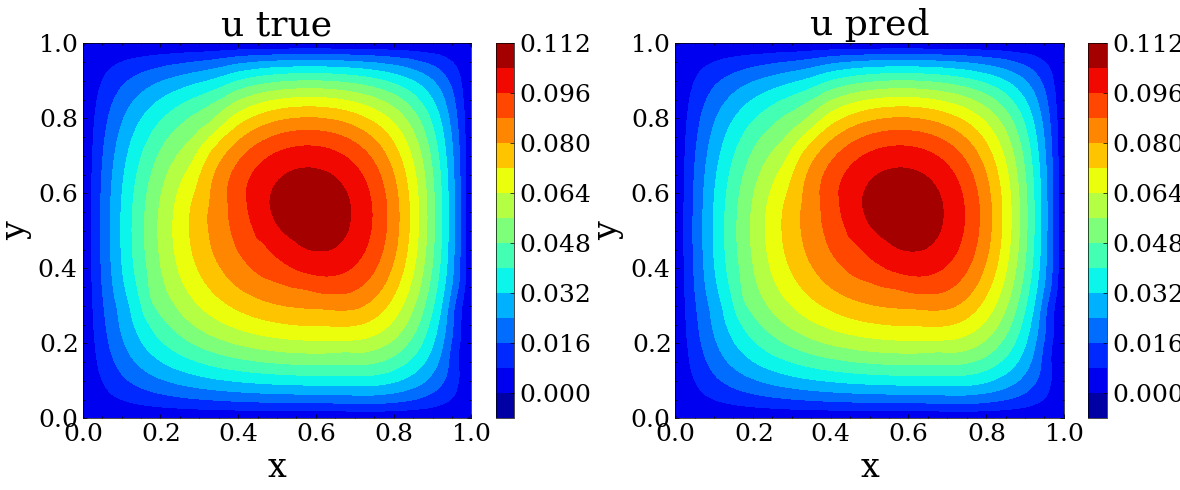

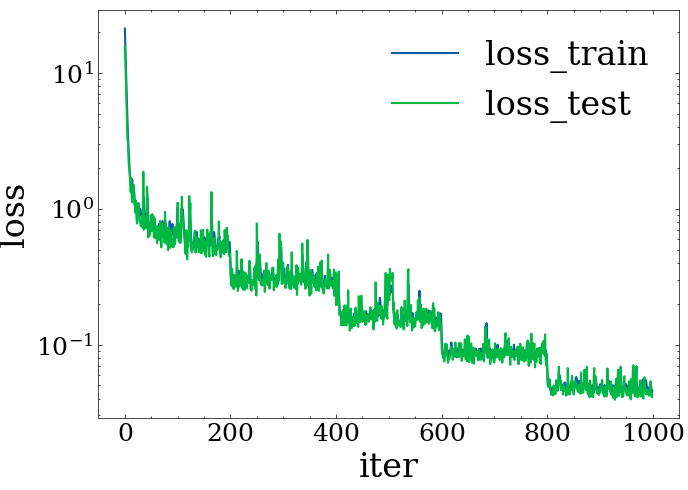

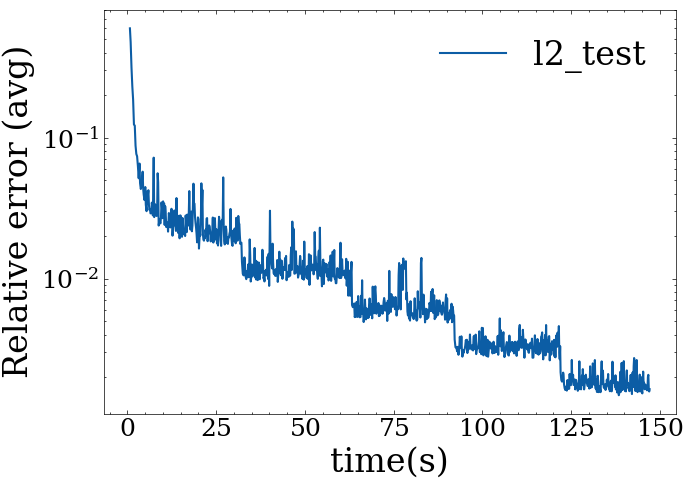

In [3]:
#####################################
# Load the trained model
#####################################
from Solvers.FNO import FNO
solver = FNO.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', name='model_fno_final')

#########################################
with torch.no_grad():
    ax = normalizer_ax.encode(ax_test.to(device))
    u_pred = model_trained['u'](ax)
    u_pred = normalizer_u.decode(u_pred).detach().cpu()
# 
u_pred = u_pred.reshape(u_pred.shape[0], -1, 1)
u_test = u_test.reshape(u_test.shape[0], -1, 1)
print('The shape of ax_norm:', ax.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of u_pred:', u_pred.shape)
print('The shape of meshgrid:', grid_test.shape)
print('The test loss', solver.getLoss(u_pred, u_test))
print('The test l2 error:', solver.getError(u_pred, u_test))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(grid_test, [u_test[0], u_pred[0]], ['u true', 'u pred'], lb=0.)
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_fno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# # show error
Plot.show_error([loss_saved['time']]*2, [loss_saved['l2_test']], ['l2_test'])